In [30]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
import adapters
from adapters import AutoAdapterModel
from sentence_transformers import SentenceTransformer
import gc

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

from openTSNE import TSNE, affinity

import matplotlib.pyplot as plt
import matplotlib

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [73]:
%load_ext autoreload
%autoreload 2

from metrics import knn_accuracy
from embeddings import generate_embeddings
from plotting import plot_tsne_colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [12]:
variables_path = Path("../results/variables/iclr24v2")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [13]:
plt.style.use("matplotlib_style.txt")

In [14]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers,openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-03-19 03:08:08CET

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

transformers: 4.35.2
openTSNE    : 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

sklearn        : 1.3.2
openTSNE       : 1.0.0
black          : 23.11.0
scipy          : 1.11.4
numpy          : 1.26.2
adapters       : 0.1.0
matplotlib     : 3.8.2
memory_profiler: 0.61.0
distro         : 1.8.0
pandas         : 2.1.3
jupyter_black  : 0.3.4
torch          : 2.1.1

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Import

In [18]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr24v2.parquet",
    engine="pyarrow",
)

CPU times: user 184 ms, sys: 97.6 ms, total: 282 ms
Wall time: 220 ms


In [19]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [20]:
iclr2024

year          id                                              title  \
0      2017   B1-Hhnslg        Prototypical Networks for Few-shot Learning   
1      2017   B1-q5Pqxl  Machine Comprehension Using Match-LSTM and Ans...   
2      2017   B16Jem9xe             Learning in Implicit Generative Models   
3      2017   B16dGcqlx                    Third Person Imitation Learning   
4      2017   B184E5qee  Improving Neural Language Models with a Contin...   
...     ...         ...                                                ...   
24343  2024  zxPDdw8koz  CLIP meets Model Zoo Experts: Pseudo-Supervisi...   
24344  2024  zyBJodMrn5  On the generalization capacity of neural netwo...   
24345  2024  zz61V8bIab  Stochastic Adversarial Networks for Multi-Doma...   
24346  2024  zzqn5G9fjn  Breaking Physical and Linguistic Borders: Mult...   
24347  2024  zzv4Bf50RW  Learning SO(3)-Invariant Correspondence via Po...   

                                                abstract  \
0      A recent approach to few-shot classification c...   
1      Machine comprehension of text is an important ...   
2      Generative adversarial networks (GANs) provide...   
3      Reinforcement learning (RL) makes it possible ...   
4      We propose an extension to neural network lang...   
...                                                  ...   
24343  Contrastive language image pretraining (CLIP) ...   
24344  The advent of the Transformer has led to the d...   
24345  Adversarial training has played a pivotal role...   
24346  Pretrained large language models (LLMs) have e...   
24347  Establishing accurate dense 3D correspondences...   

                                                 authors  \
0               Jake Snell, Kevin Swersky, Richard Zemel   
1                              Shuohang Wang, Jing Jiang   
2                Shakir Mohamed, Balaji Lakshminarayanan   
3         Bradly C Stadie, Pieter Abbeel, Ilya Sutskever   
4          Edouard Grave, Armand Joulin, Nicolas Usunier   
...                                                  ...   
24343                                                      
24344  Takuya Ito, Soham Dan, Mattia Rigotti, James K...   
24345                                                      
24346  Wanru Zhao, Royson Lee, Yihong Chen, Xinchi Qi...   
24347                                                      

                       decision           scores  \
0                        Reject        [6, 4, 5]   
1               Accept (Poster)        [6, 6, 7]   
2      Invite to Workshop Track        [8, 7, 6]   
3               Accept (Poster)        [6, 5, 6]   
4               Accept (Poster)        [7, 9, 5]   
...                         ...              ...   
24343                 Withdrawn     [8, 3, 3, 3]   
24344           Accept (poster)        [8, 3, 6]   
24345                 Withdrawn        [5, 1, 5]   
24346           Accept (poster)     [5, 3, 1, 8]   
24347                 Withdrawn  [5, 5, 3, 5, 6]   

                                                keywords  \
0                     [deep learning, transfer learning]   
1           [natural language processing, deep learning]   
2                                [unsupervised learning]   
3                                                     []   
4                          [natural language processing]   
...                                                  ...   
24343  [contrastive learning, clip, distillation, den...   
24344  [compositional generalization, compositionalit...   
24345  [multi-domain text classification, adversarial...   
24346  [multilingual federated learning, natural lang...   
24347  [point cloud understanding, 3d dense correspon...   

                       labels  
0           transfer learning  
1             language models  
2                   unlabeled  
3                   unlabeled  
4             language models  
...                       ...  
24343  vision-language models  
24344     out-of-distribut

In [29]:
labels_iclr = iclr2024.labels.to_numpy()

In [21]:
colors_iclr = np.load(variables_path / "colors_iclr.npy")

pickle_in = open(variables_path / "dict_label_to_color.pkl", "rb")
dict_label_to_color = pickle.load(pickle_in)

# Obtain representation

## BERT-based models

### General pipeline

In [25]:
model_names = [
    "SimCSE",
    "DeCLUTR-sci",
    "SciNCL",
    # "SPECTER2",
    # "ST5",
    "SBERT",
]


model_paths = [
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-sci-base",
    "malteos/scincl",
    # "allenai/specter2_base",
    # "sentence-transformers/sentence-t5-base",
    "sentence-transformers/all-mpnet-base-v2",
]
print(model_names)

['SimCSE', 'DeCLUTR-sci', 'SciNCL', 'SBERT']


In [26]:
%%time
for i, model_name in enumerate(model_names):
    # set up model
    print("Model: ", model_name)

    random_state = random.seed(42)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    model = model.to(device)

    # get embeddings
    embedding_cls, embedding_sep, embedding_av = generate_embeddings(
        iclr2024.abstract.to_list(), tokenizer, model, device, batch_size=256
    )

    # save embeddings
    saving_path = Path("embeddings_" + model_name.lower())
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(
        variables_path / saving_path / "embedding_abstracts_only_cls",
        embedding_cls,
    )
    np.save(
        variables_path / saving_path / "embedding_abstracts_only_sep",
        embedding_sep,
    )
    np.save(
        variables_path / saving_path / "embedding_abstracts_only_av",
        embedding_av,
    )

    model = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  SimCSE
Running on device: cuda
princeton-nlp/unsup-simcse-bert-base-uncased


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  DeCLUTR-sci
Running on device: cuda
johngiorgi/declutr-sci-base


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SciNCL
Running on device: cuda
malteos/scincl


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 7min 37s, sys: 12min 41s, total: 20min 19s
Wall time: 13min 35s


### SPECTER2

In [27]:
%%time
# SPECTER 2
model_name = "SPECTER2"
model_path = "allenai/specter2_base"

# set up model
print('Model: ', model_name)

random_state = random.seed(42)
device = (
    "cuda" if torch.cuda.is_available() else "cpu"
)  
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoAdapterModel.from_pretrained(model_path)
print(model_path)
# add adapter proximity
#load the adapter(s) as per the required task, provide an identifier for the adapter in load_as argument and activate it
model.load_adapter("allenai/specter2", source="hf", load_as="specter2", set_active=True)

model = model.to(device)

# get embeddings
embedding_cls, embedding_sep, embedding_av = generate_embeddings(iclr2024.abstract.to_list(), tokenizer, model, device, batch_size=256)

# save embeddings
saving_path = Path("embeddings_" + model_name.lower())
(variables_path / saving_path).mkdir(parents=True,exist_ok=True)

np.save(variables_path/saving_path/"embedding_abstracts_only_cls", embedding_cls)
np.save(variables_path/saving_path/"embedding_abstracts_only_sep", embedding_sep)
np.save(variables_path/saving_path/"embedding_abstracts_only_av", embedding_av)

model = None
gc.collect()
torch.cuda.empty_cache()

print('----------------------------')



Model:  SPECTER2
Running on device: cuda
allenai/specter2_base


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 1min 53s, sys: 3min 10s, total: 5min 4s
Wall time: 3min 35s


### ST5

In [32]:
%%time
# ST5
model_name = "ST5"
model_path = "sentence-transformers/sentence-t5-base"

# set up model
print("Model: ", model_name)

random_state = random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

print(model_path)
model = SentenceTransformer(model_path, device="cuda")

# get embeddings
embedding_av = model.encode(
    iclr2024.abstract.to_list(),
    batch_size=256,
    show_progress_bar=True,
    output_value="sentence_embedding",
    device="cuda",
    normalize_embeddings=False,  # the output is still normalized for some reason
)

# save embeddings
saving_path = Path("embeddings_" + model_name.lower())
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(
    variables_path / saving_path / "embedding_abstracts_only_av", embedding_av
)

model = None
gc.collect()
torch.cuda.empty_cache()

print("----------------------------")

Model:  ST5
Running on device: cuda
sentence-transformers/sentence-t5-base


Batches:   0%|          | 0/96 [00:00<?, ?it/s]

----------------------------
CPU times: user 2min 43s, sys: 1min 19s, total: 4min 3s
Wall time: 1min 26s


## TF-IDF

In [33]:
%%time
%%memit

# TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features = vectorizer.fit_transform(iclr2024.abstract.to_list())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 3652.59 MiB, increment: 0.03 MiB
CPU times: user 2.22 s, sys: 206 ms, total: 2.43 s
Wall time: 2.62 s


In [34]:
print(tfidf_features.shape)

(24348, 44434)


In [35]:
# save results
sp.sparse.save_npz(variables_path / "tfidf_features", tfidf_features)

## Truncated SVD

In [36]:
%%time
%%memit

# TruncatedSVD
svd = TruncatedSVD(n_components=768, random_state=42, algorithm="arpack")
svd_data = svd.fit_transform(tfidf_features)

# save results
np.save(variables_path / "svd_data", svd_data)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 3652.61 MiB, increment: 0.00 MiB
CPU times: user 47min 7s, sys: 38min 25s, total: 1h 25min 32s
Wall time: 2min 13s


# kNN accuracy

## BERT-based models

In [37]:
model_names = [
    "SimCSE",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER2",
    "ST5",
    "SBERT",
]


model_paths = [
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-sci-base",
    "malteos/scincl",
    "allenai/specter2_base",
    "sentence-transformers/sentence-t5-base",
    "sentence-transformers/all-mpnet-base-v2",
]
print(model_names)

['SimCSE', 'DeCLUTR-sci', 'SciNCL', 'SPECTER2', 'ST5', 'SBERT']


### Euclidean

In [120]:
%%time
%%memit
print("kNN accuracy     [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # import
    saving_path = Path("embeddings_" + model_name.lower())

    if model_name != "ST5":
        embedding_cls = np.load(
            variables_path / saving_path / "embedding_abstracts_only_cls.npy"
        )
        embedding_sep = np.load(
            variables_path / saving_path / "embedding_abstracts_only_sep.npy"
        )

    embedding_av = np.load(
        variables_path / saving_path / "embedding_abstracts_only_av.npy"
    )

    # knn acc
    if model_name == "ST5":
        knn_acc = knn_accuracy(
            embedding_av[labels_iclr != "unlabeled"],
            labels_iclr[labels_iclr != "unlabeled"],
            metric="euclidean",
        )
    else:
        knn_acc = knn_accuracy(
            [
                embedding_av[labels_iclr != "unlabeled"],
                embedding_cls[labels_iclr != "unlabeled"],
                embedding_sep[labels_iclr != "unlabeled"],
            ],
            labels_iclr[labels_iclr != "unlabeled"],
            metric="euclidean",
        )

    print(f"{model_name}: {np.round(np.array(knn_acc)*100,1)}")

    # save embeddings
    saving_name = Path("knn_accuracy_" + model_name.lower())
    np.save(variables_path / saving_name, knn_acc)

    # print("----------------------------")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


kNN accuracy     [AVG]    [CLS]   [SEP]
SimCSE: [44.9 47.1 44.4]
DeCLUTR-sci: [53.4 40.1 32.2]
SciNCL: [57.2 59.7 59. ]
SPECTER2: [57.3 58.7 61.5]
ST5: 57.0
SBERT: [62.9 63.1 62.3]
peak memory: 4352.59 MiB, increment: 120.82 MiB
CPU times: user 39.3 s, sys: 5.05 s, total: 44.4 s
Wall time: 3.92 s


In [121]:
%%time
%%memit
print("kNN accuracy     [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # print("Model: ", model_name)

    # save embeddings
    saving_name = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc = np.load(variables_path / saving_name)
    print(f"{model_name}: {np.round(np.array(knn_acc)*100,1)}")

    # print("----------------------------")

kNN accuracy     [AVG]    [CLS]   [SEP]
SimCSE: [44.9 47.1 44.4]
DeCLUTR-sci: [53.4 40.1 32.2]
SciNCL: [57.2 59.7 59. ]
SPECTER2: [57.3 58.7 61.5]
ST5: 57.0
SBERT: [62.9 63.1 62.3]
peak memory: 4352.61 MiB, increment: 0.00 MiB
CPU times: user 411 ms, sys: 94.5 ms, total: 505 ms
Wall time: 634 ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Cosine

In [117]:
model_names = [
    "SimCSE",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER2",
    "ST5",
    "SBERT",
]


model_paths = [
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-sci-base",
    "malteos/scincl",
    "allenai/specter2_base",
    "sentence-transformers/sentence-t5-base",
    "sentence-transformers/all-mpnet-base-v2",
]
print(model_names)

['SimCSE', 'DeCLUTR-sci', 'SciNCL', 'SPECTER2', 'ST5', 'SBERT']


In [119]:
%%time
%%memit
print("kNN accuracy     [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # import
    saving_path = Path("embeddings_" + model_name.lower())

    if model_name != "ST5":
        embedding_cls = np.load(
            variables_path / saving_path / "embedding_abstracts_only_cls.npy"
        )
        embedding_sep = np.load(
            variables_path / saving_path / "embedding_abstracts_only_sep.npy"
        )

    embedding_av = np.load(
        variables_path / saving_path / "embedding_abstracts_only_av.npy"
    )

    # knn acc
    if model_name == "ST5":
        knn_acc = knn_accuracy(
            embedding_av[labels_iclr != "unlabeled"],
            labels_iclr[labels_iclr != "unlabeled"],
            metric="cosine",
        )
    else:
        knn_acc = knn_accuracy(
            [
                embedding_av[labels_iclr != "unlabeled"],
                embedding_cls[labels_iclr != "unlabeled"],
                embedding_sep[labels_iclr != "unlabeled"],
            ],
            labels_iclr[labels_iclr != "unlabeled"],
            metric="cosine",
        )

    print(f"{model_name}: {np.round(np.array(knn_acc)*100,1)}")

    # save embeddings
    saving_name = Path("knn_accuracy_cosine_" + model_name.lower())
    np.save(variables_path / saving_name, knn_acc)

    # print("----------------------------")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


kNN accuracy     [AVG]    [CLS]   [SEP]
SimCSE: [46.7 47.3 44.5]
DeCLUTR-sci: [53.8 40.  32.1]
SciNCL: [56.3 59.4 59.4]
SPECTER2: [57.7 58.9 61.4]
ST5: 57.0
SBERT: [62.  62.6 62.5]
peak memory: 4578.88 MiB, increment: 77.01 MiB
CPU times: user 2min 36s, sys: 5min 27s, total: 8min 4s
Wall time: 12.9 s


## TF-IDF

In [44]:
# save results
tfidf_features = sp.sparse.load_npz(variables_path / "tfidf_features.npz")

### Euclidean

In [45]:
%%time
%%memit

knn_accuracy_tfidf = knn_accuracy(
    tfidf_features[labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
)

np.save(
    variables_path / "knn_accuracy_tfidf",
    knn_accuracy_tfidf,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 4180.34 MiB, increment: 7.45 MiB
CPU times: user 2min 33s, sys: 3.4 s, total: 2min 37s
Wall time: 7.73 s


In [46]:
print(knn_accuracy_tfidf * 100)

58.95465026902382


### Cosine

In [47]:
%%time
%%memit

knn_accuracy_tfidf = knn_accuracy(
    tfidf_features[labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
    metric="cosine",
)
np.save(
    variables_path / "knn_accuracy_cosine_tfidf",
    knn_accuracy_tfidf,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 4303.26 MiB, increment: 122.91 MiB
CPU times: user 3.38 s, sys: 666 ms, total: 4.05 s
Wall time: 1.19 s


In [48]:
print(knn_accuracy_tfidf * 100)

58.95465026902382


## SVD

In [49]:
svd_data = np.load(variables_path / "svd_data.npy")

### Euclidean

In [50]:
%%time
knn_accuracy_svd = knn_accuracy(
    svd_data[:, :100][labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
)

np.save(variables_path / "knn_accuracy_svd", knn_accuracy_svd)

CPU times: user 3.37 s, sys: 3.31 s, total: 6.68 s
Wall time: 180 ms


In [51]:
print(knn_accuracy_svd * 100)

58.80092236740968


### Cosine

In [52]:
%%time
knn_accuracy_svd = knn_accuracy(
    svd_data[:, :100][labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
    metric="cosine",
)

np.save(
    variables_path / "knn_accuracy_cosine_svd",
    knn_accuracy_svd,
)

CPU times: user 8.68 s, sys: 24 s, total: 32.7 s
Wall time: 796 ms


In [57]:
print(knn_accuracy_svd * 100)

61.95234435049961


## L2(SVD)

In [54]:
# svd_data = np.load(variables_path / "svd_data.npy")

In [55]:
%%time
knn_accuracy_L2_svd = knn_accuracy(
    normalize(svd_data[labels_iclr != "unlabeled"][:, :100], axis=1),
    labels_iclr[labels_iclr != "unlabeled"],
)

np.save(variables_path / "knn_accuracy_L2_svd", knn_accuracy_L2_svd)

CPU times: user 915 ms, sys: 15.9 ms, total: 931 ms
Wall time: 113 ms


In [56]:
print(knn_accuracy_L2_svd * 100)

61.95234435049961


# t-SNE

## BERT-based models

In [89]:
model_names = [
    "SimCSE",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER2",
    "ST5",
    "SBERT",
]


model_paths = [
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-sci-base",
    "malteos/scincl",
    "allenai/specter2_base",
    "sentence-transformers/sentence-t5-base",
    "sentence-transformers/all-mpnet-base-v2",
]
print(model_names)

['SimCSE', 'DeCLUTR-sci', 'SciNCL', 'SPECTER2', 'ST5', 'SBERT']


In [90]:
%%time
%%memit
print("kNN accuracy          [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # import
    saving_path = Path("embeddings_" + model_name.lower())

    embedding_av = np.load(
        variables_path / saving_path / "embedding_abstracts_only_av.npy"
    )

    if model_name != "ST5":
        embedding_cls = np.load(
            variables_path / saving_path / "embedding_abstracts_only_cls.npy"
        )
        embedding_sep = np.load(
            variables_path / saving_path / "embedding_abstracts_only_sep.npy"
        )

        # t-SNE
        tsne_cls = TSNE(verbose=True, random_state=42).fit(embedding_cls)
        tsne_sep = TSNE(verbose=True, random_state=42).fit(embedding_sep)

    tsne_av = TSNE(verbose=True, random_state=42).fit(embedding_av)

    # save
    if model_name != "ST5":
        np.save(variables_path / saving_path / "tsne_cls.npy", tsne_cls)
        np.save(variables_path / saving_path / "tsne_sep.npy", tsne_sep)
    np.save(variables_path / saving_path / "tsne_av.npy", tsne_av)

    # knn acc
    if model_name == "ST5":
        knn_acc = knn_accuracy(
            [
                tsne_av[labels_iclr != "unlabeled"],
            ],
            labels_iclr[labels_iclr != "unlabeled"],
        )
    else:
        knn_acc = knn_accuracy(
            [
                tsne_av[labels_iclr != "unlabeled"],
                tsne_cls[labels_iclr != "unlabeled"],
                tsne_sep[labels_iclr != "unlabeled"],
            ],
            labels_iclr[labels_iclr != "unlabeled"],
        )

    print(f"t-SNE {model_name}: {np.array(knn_acc)*100}")

    # save embeddings
    saving_name = Path("knn_accuracy_tsne_" + model_name.lower())
    np.save(variables_path / saving_name, knn_acc)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


kNN accuracy          [AVG]    [CLS]   [SEP]
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 81.55 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.62 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.40 seconds
===> Running optimization with exaggeration=12.00, lr=2029.00 for 250 iterations...
Iteration   50, KL divergence 6.3093, 50 iterations in 1.9195 sec
Iteration  100, KL divergence 6.3086, 50 iterations in 1.9029 sec
Iteration  150, KL divergence 6.3082, 50 iterations in 1.9066 sec
Iteration  200, KL divergence 6.3161, 50 iterations in 1.9018 sec
Iteration  250, KL divergence 6.3162, 50 iterations in 1.9181 sec
   --> Time elapsed: 9.55 seconds
===> Runn

In [91]:
%%time
%%memit
print("kNN accuracy     [AVG] [CLS] [SEP]")
for i, model_name in enumerate(model_names):
    # print("Model: ", model_name)

    # save embeddings
    saving_name = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc = np.load(variables_path / saving_name)
    print(f"{model_name}:          {np.round(np.array(knn_acc)*100,1)}")

    saving_name = Path("knn_accuracy_tsne_" + model_name.lower() + ".npy")
    knn_acc = np.load(variables_path / saving_name)
    print(f"t-SNE {model_name}:    {np.round(np.array(knn_acc)*100,1)}")

    print("----------------------------------")

kNN accuracy     [AVG] [CLS] [SEP]
SimCSE:          [44.9 47.1 44.4]
t-SNE SimCSE:    [41.  38.5 36.4]
----------------------------------
DeCLUTR-sci:          [53.4 40.1 32.2]
t-SNE DeCLUTR-sci:    [48.  32.1 22.3]
----------------------------------
SciNCL:          [57.2 59.7 59. ]
t-SNE SciNCL:    [50.5 54.1 57.1]
----------------------------------
SPECTER2:          [57.3 58.7 61.5]
t-SNE SPECTER2:    [52.6 54.9 58.3]
----------------------------------
ST5:          57.0
t-SNE ST5:    [52.6]
----------------------------------
SBERT:          [62.9 63.1 62.3]
t-SNE SBERT:    [57.6 56.8 57.4]
----------------------------------
peak memory: 4451.29 MiB, increment: 0.00 MiB
CPU times: user 283 ms, sys: 101 ms, total: 384 ms
Wall time: 517 ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [92]:
%%time
%%memit
print("kNN accuracy          [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # save embeddings
    saving_name = Path("knn_accuracy_tsne_" + model_name.lower() + ".npy")
    knn_acc = np.load(variables_path / saving_name)
    print(f"t-SNE {model_name}: {np.round(np.array(knn_acc)*100,1)}")

    # print("----------------------------")

kNN accuracy          [AVG]    [CLS]   [SEP]
t-SNE SimCSE: [41.  38.5 36.4]
t-SNE DeCLUTR-sci: [48.  32.1 22.3]
t-SNE SciNCL: [50.5 54.1 57.1]
t-SNE SPECTER2: [52.6 54.9 58.3]
t-SNE ST5: [52.6]
t-SNE SBERT: [57.6 56.8 57.4]
peak memory: 4448.30 MiB, increment: 0.00 MiB
CPU times: user 277 ms, sys: 69.5 ms, total: 347 ms
Wall time: 494 ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## TF-IDF -- RERUN

In [ ]:
# import
#tfidf_features = sp.sparse.load_npz(variables_path / "tfidf_features.npz")

# svd_data = np.load(variables_path / "svd_data.npy")

In [132]:
%%time
%%memit

A = affinity.PerplexityBasedNN(
    tfidf_features,
    verbose=True,
    method="exact",
    random_state=42,
)
tsne_tfidf = TSNE(verbose=True, random_state=42).fit(
    tfidf_features,
    affinities=A,
    initialization=svd_data[:, :2],
)

np.save(variables_path / "tsne_tfidf", tsne_tfidf)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 195.14 seconds
===> Calculating affinity matrix...


   --> Time elapsed: 0.73 seconds
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=2029.00 for 250 iterations...
Iteration   50, KL divergence 6.2053, 50 iterations in 1.8807 sec
Iteration  100, KL divergence 6.2024, 50 iterations in 1.8622 sec
Iteration  150, KL divergence 6.2021, 50 iterations in 1.8389 sec
Iteration  200, KL divergence 6.2006, 50 iterations in 1.8009 sec
Iteration  250, KL divergence 6.2005, 50 iterations in 1.7902 sec
   --> Time elapsed: 9.17 seconds
===> Running optimization with exaggeration=1.00, lr=24348.00 for 500 iterations...
Iteration   50, KL divergence 3.8923, 50 iterations in 1.7905 sec
Iteration  100, KL divergence 3.6556, 50 iterations in 2.2574 sec
Iteration  150, KL divergence 3.5422, 50 iterations in 3.0482 sec
Iteration  200,

In [134]:
%%time

knn_accuracy_tsne_tfidf = knn_accuracy(
    tsne_tfidf[labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
)
np.save(
    variables_path / "knn_accuracy_tsne_tfidf",
    knn_accuracy_tsne_tfidf,
)

CPU times: user 734 ms, sys: 49.7 ms, total: 784 ms
Wall time: 85.2 ms


In [135]:
print(knn_accuracy_tsne_tfidf * 100)

52.88239815526518


## SVD

In [65]:
# svd_data = np.load(variables_path / "svd_data.npy")

In [96]:
%%time
%%memit

tsne_svd = TSNE(verbose=True, random_state=42).fit(svd_data[:, :100])

np.save(variables_path / "tsne_svd", tsne_svd)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 14.29 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.74 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.23 seconds
===> Running optimization with exaggeration=12.00, lr=2029.00 for 250 iterations...
Iteration   50, KL divergence 6.1356, 50 iterations in 1.9969 sec
Iteration  100, KL divergence 6.0593, 50 iterations in 1.9388 sec
Iteration  150, KL divergence 6.0567, 50 iterations in 1.9500 sec
Iteration  200, KL divergence 6.0615, 50 iterations in 1.9400 sec
Iteration  250, KL divergence 6.0657, 50 iterations in 1.9432 sec
   --> Time elapsed: 9.77 seconds
===> Running optimization with exaggeration=1.00, lr=2

In [97]:
%%time
%%memit

knn_accuracy_tsne_svd = knn_accuracy(
    tsne_svd[labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
)
np.save(
    variables_path / "knn_accuracy_tsne_svd",
    knn_accuracy_tsne_svd,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 4464.46 MiB, increment: 7.66 MiB
CPU times: user 2.85 s, sys: 5.25 s, total: 8.11 s
Wall time: 750 ms


In [98]:
print(knn_accuracy_tsne_svd * 100)

56.341275941583405


## L2(SVD)

In [ ]:
#svd_data = np.load(variables_path / "svd_data.npy")

In [99]:
%%time
%%memit

tsne_L2_svd = TSNE(verbose=True, random_state=42).fit(
    normalize(svd_data[:, :100], axis=1)
)

np.save(variables_path / "tsne_L2_svd", tsne_L2_svd)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 14.05 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.69 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.41 seconds
===> Running optimization with exaggeration=12.00, lr=2029.00 for 250 iterations...
Iteration   50, KL divergence 6.0768, 50 iterations in 1.7471 sec
Iteration  100, KL divergence 6.1378, 50 iterations in 1.7380 sec
Iteration  150, KL divergence 6.1387, 50 iterations in 1.7241 sec
Iteration  200, KL divergence 6.1388, 50 iterations in 1.7306 sec
Iteration  250, KL divergence 6.1388, 50 iterations in 1.7269 sec
   --> Time elapsed: 8.67 seconds
===> Running optimization with exaggeration=1.00, lr=2

In [100]:
%%time
%%memit

knn_accuracy_tsne_L2_svd = knn_accuracy(
    tsne_L2_svd[labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
)
np.save(
    variables_path / "knn_accuracy_tsne_L2_svd",
    knn_accuracy_tsne_L2_svd,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 4459.07 MiB, increment: 7.93 MiB
CPU times: user 2.8 s, sys: 5.16 s, total: 7.96 s
Wall time: 820 ms


In [102]:
print(knn_accuracy_tsne_L2_svd * 100)

57.10991544965411


## Plot

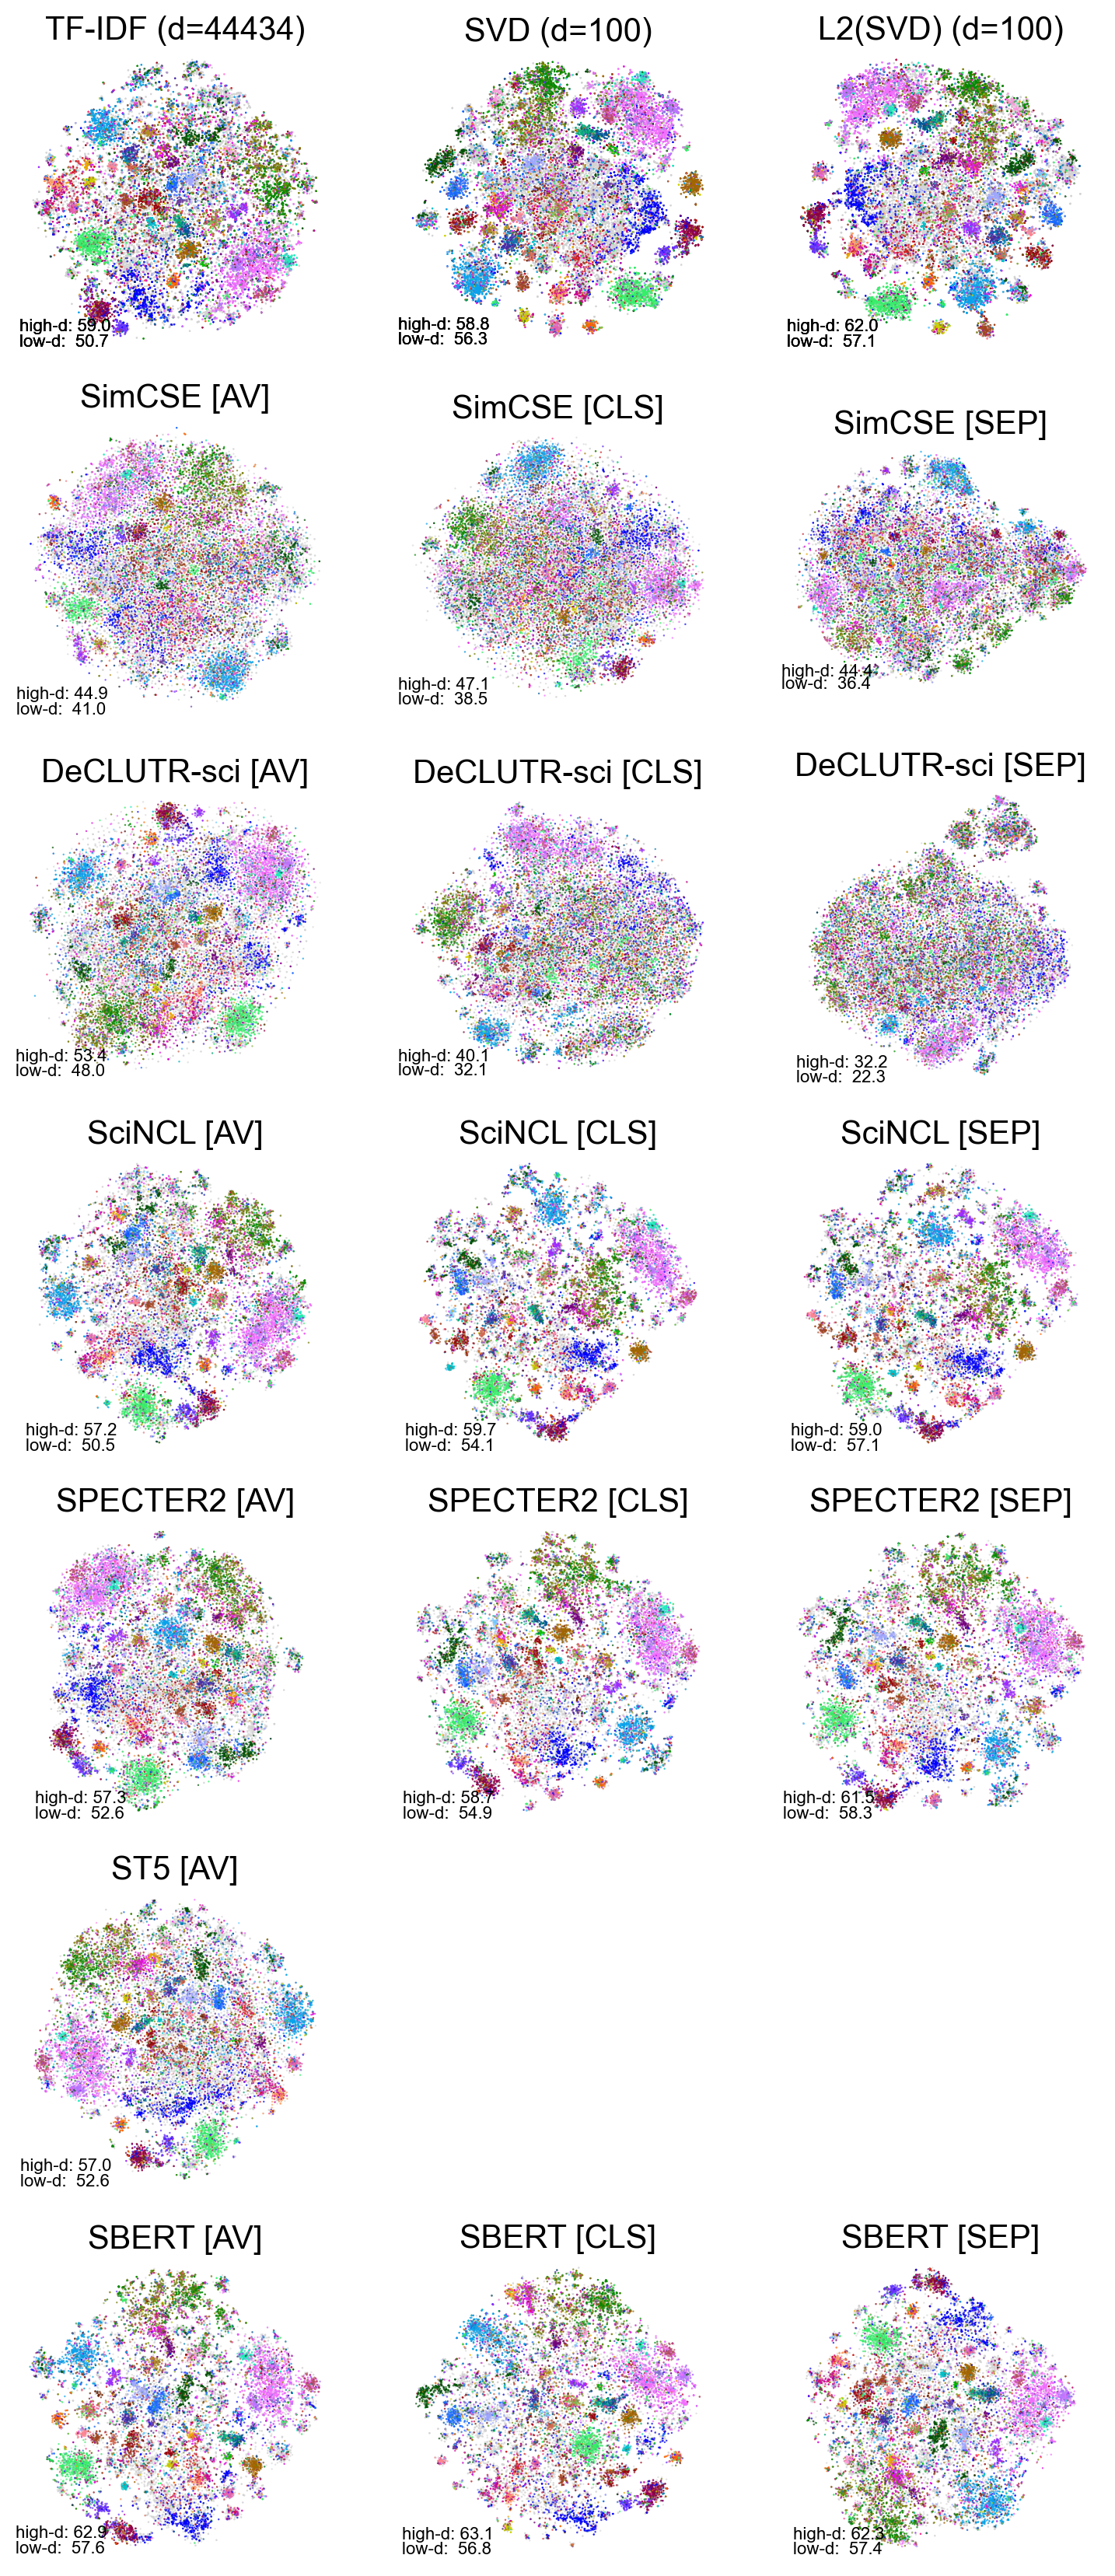

In [116]:
fig, axs = plt.subplots(
    len(model_names) + 1, 3, figsize=(9, 3 * (len(model_names) + 1)), dpi=200
)
rep = ["av", "cls", "sep"]
acc_fontsize = 8
for i in range(len(model_names) + 1):
    for j in range(3):
        if i == 0:
            # load
            ## tsnes
            tsne_tfidf = np.load(variables_path / "tsne_tfidf.npy")
            tsne_svd = np.load(variables_path / "tsne_svd.npy")
            tsne_L2_svd = np.load(variables_path / "tsne_L2_svd.npy")

            ## accuracies
            knn_accuracy_tfidf = np.load(
                variables_path / "knn_accuracy_tfidf.npy"
            )
            knn_accuracy_svd = np.load(variables_path / "knn_accuracy_svd.npy")
            knn_accuracy_L2_svd = np.load(
                variables_path / "knn_accuracy_L2_svd.npy"
            )

            knn_accuracy_tsne_tfidf = np.load(
                variables_path / "knn_accuracy_tsne_tfidf.npy"
            )
            knn_accuracy_tsne_svd = np.load(
                variables_path / "knn_accuracy_tsne_svd.npy"
            )
            knn_accuracy_tsne_L2_svd = np.load(
                variables_path / "knn_accuracy_tsne_L2_svd.npy"
            )

            plot_tsne_colors(
                tsne_tfidf, colors_iclr, ax=axs[i, 0], plot_type="subplot_3"
            )
            axs[i, 0].set_title(f"TF-IDF (d=44434)", fontsize=15)

            axs[i, 0].text(
                0,
                0.06,
                f"high-d: {knn_accuracy_tfidf*100:.1f}",
                transform=axs[i, 0].transAxes,
                va="bottom",
                ha="left",
                size=acc_fontsize,
            )
            axs[i, 0].text(
                0,
                0.01,
                f"low-d:  {knn_accuracy_tsne_tfidf*100:.1f}",
                transform=axs[i, 0].transAxes,
                va="bottom",
                ha="left",
                size=acc_fontsize,
            )

            plot_tsne_colors(
                tsne_svd,
                colors_iclr,
                ax=axs[i, 1],
                plot_type="subplot_3",
            )
            axs[i, 1].set_title("SVD (d=100)", fontsize=15)
            axs[i, 1].text(
                0,
                0.06,
                f"high-d: {knn_accuracy_svd*100:.1f}",
                transform=axs[i, 1].transAxes,
                va="bottom",
                ha="left",
                size=acc_fontsize,
            )
            axs[i, 1].text(
                0,
                0.01,
                f"low-d:  {knn_accuracy_tsne_svd*100:.1f}",
                transform=axs[i, 1].transAxes,
                va="bottom",
                ha="left",
                size=acc_fontsize,
            )

            plot_tsne_colors(
                tsne_L2_svd,
                colors_iclr,
                ax=axs[i, 2],
                plot_type="subplot_3",
            )
            axs[i, 2].set_title("L2(SVD) (d=100)", fontsize=15)
            axs[i, 2].text(
                0,
                0.06,
                f"high-d: {knn_accuracy_L2_svd*100:.1f}",
                transform=axs[i, 2].transAxes,
                va="bottom",
                ha="left",
                size=acc_fontsize,
            )
            axs[i, 2].text(
                0,
                0.01,
                f"low-d:  {knn_accuracy_tsne_L2_svd*100:.1f}",
                transform=axs[i, 2].transAxes,
                va="bottom",
                ha="left",
                size=acc_fontsize,
            )
        else:
            # break
            # load
            ## tsnes
            if (model_names[i - 1] == "ST5") & ((j == 1) | (j == 2)):
                axs[i, j].axis("off")
                continue

            else:
                saving_path = Path("embeddings_" + model_names[i - 1].lower())
                tsne_name = "tsne_" + rep[j] + ".npy"
                tsne = np.load(variables_path / saving_path / tsne_name)

                ## accuracies
                saving_name = Path(
                    "knn_accuracy_" + model_names[i - 1].lower() + ".npy"
                )
                knn_acc_highd = np.load(variables_path / saving_name)

                saving_name = Path(
                    "knn_accuracy_tsne_" + model_names[i - 1].lower() + ".npy"
                )
                knn_acc_lowd = np.load(variables_path / saving_name)

                # plot
                plot_tsne_colors(
                    tsne, colors_iclr, ax=axs[i, j], plot_type="subplot_3"
                )
                title = model_names[i - 1] + " [" + rep[j].upper() + "]"
                axs[i, j].set_title(title, fontsize=15)

                if model_names[i - 1] == "ST5":
                    axs[i, j].text(
                        0,
                        0.06,
                        f"high-d: {knn_acc_highd*100:.1f}",
                        transform=axs[i, j].transAxes,
                        va="bottom",
                        ha="left",
                        size=acc_fontsize,
                    )
                    axs[i, j].text(
                        0,
                        0.01,
                        f"low-d:  {knn_acc_lowd[0]*100:.1f}",
                        transform=axs[i, j].transAxes,
                        va="bottom",
                        ha="left",
                        size=acc_fontsize,
                    )
                else:
                    axs[i, j].text(
                        0,
                        0.06,
                        f"high-d: {knn_acc_highd[j]*100:.1f}",
                        transform=axs[i, j].transAxes,
                        va="bottom",
                        ha="left",
                        size=acc_fontsize,
                    )
                    axs[i, j].text(
                        0,
                        0.01,
                        f"low-d:  {knn_acc_lowd[j]*100:.1f}",
                        transform=axs[i, j].transAxes,
                        va="bottom",
                        ha="left",
                        size=acc_fontsize,
                    )

fig.savefig(figures_path / "tsne_embeddings_iclr_with_knn_accs_v2.png")